# Final Project: 某闯关类手游用户流失预测

## 一、案例简介

手游在当下的日常娱乐中占据着主导性地位，成为人们生活中放松身心的一种有效途径。近年来，各种类型的手游，尤其是闯关类的休闲手游，由于其对碎片化时间的利用取得了非常广泛的市场。然而在此类手游中，新用户流失是一个非常严峻的问题，有相当多的新用户在短暂尝试后会选择放弃，而如果能在用户还没有完全卸载游戏的时候针对流失可能性较大的用户施以干预（例如奖励道具、暖心短信），就可能挽回用户从而提升游戏的活跃度和公司的潜在收益，因此用户的流失预测成为一个重要且挑战性的问题。在毕业项目中我们将从真实游戏中非结构化的日志数据出发，构建用户流失预测模型，综合已有知识设计适合的算法解决实际问题。

## 二、作业说明

* 根据给出的实际数据（包括用户游玩历史，关卡特征等），预测测试集中的用户是否为流失用户（二分类）；
* 方法不限，使用百度云进行评测，评价指标使用 AUC；
* 提交代码与实验报告，报告展示对数据的观察、分析、最后的解决方案以及不同尝试的对比等；
* 最终评分会参考达到的效果以及对所尝试方法的分析。

## 三、数据概览

本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。

对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。

本次的数据和以往结构化的形式不同，展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

### train.csv

训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。这里对应了2774~10931的user_id。

In [1]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
from sklearn import preprocessing, tree, ensemble, svm, metrics, calibration
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torchvision, datetime, scipy, os, torch
from sklearn.feature_extraction import text
from matplotlib import pyplot as plt
from torch.autograd import Variable
from itertools import combinations
from collections import Counter
from torch.utils import data
from tqdm import tqdm
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np


In [3]:
train_df = pd.read_csv('./data/train.csv', sep='\t')
train_df.T


,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [4]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

### dev.csv

验证集格式和训练集相同，主要为了方便离线测试与模型选择。这里对应了10932~13589的user_id。

In [121]:
dev_df = pd.read_csv('./data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### test.csv
测试集只包含用户 id，任务就是要预测这些用户的流失概率。要预测的是1~2773的user_id。

In [6]:
test_df = pd.read_csv('./data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### level_seq.csv
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：

* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；
* `level_id`：关卡 id；
* `f_success`：是否通关（1：通关，0：失败）；
* `f_duration`：此次尝试所用的时间（单位 s）；
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；
* `time`：时间戳。

In [5]:
seq_df = pd.read_csv('../data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
2034434,2557,1,1,66.0,0.500000,0,2020-02-01 22:35:06
2034435,2557,2,1,64.0,0.629630,0,2020-02-01 22:37:56
2034436,2557,3,1,103.0,0.160000,0,2020-02-02 14:34:35
2034437,2557,4,1,70.0,0.633333,0,2020-02-02 14:36:08
2034438,2557,5,0,144.0,0.000000,0,2020-02-02 14:38:42
2034439,2557,5,0,98.0,0.000000,0,2020-02-02 14:40:51
2034440,2557,5,1,96.0,0.125000,0,2020-02-02 14:42:30
2034441,2557,6,1,102.0,0.257143,0,2020-02-02 14:44:22
2034442,2557,7,0,131.0,0.000000,0,2020-02-02 14:46:42
2034443,2557,7,1,92.0,0.333333,0,2020-02-02 14:48:18


### level_meta.csv
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：

* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；
* `f_avg_passrate`：平均通关率；
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [8]:
meta_df = pd.read_csv('./data/level_meta.csv', sep='\t')
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


## 四、Tips

* 一个基本的思路可以是：根据游玩关卡的记录为每个用户提取特征 → 结合 label 构建表格式的数据集 → 使用不同模型训练与测试；
* 还可以借助其他模型（如循环神经网络）直接对用户历史序列建模；
* 数据量太大运行时间过长的话，可以先在一个采样的小训练集上调参；
* 集成多种模型往往能达到更优的效果；
* 可以使用各种开源工具。


---
---
# <center>Final Project: 某闯关类手游用户流失预测</center>

## 1 数据预处理
重构数据集为每个用户为一个样本，将从以下几个维度刻画该用户，不同维度包含以下特征：
- 是否上瘾：
    - `day`：登录天数，很多用户的留存原因是每日签到
    - `login`：登录次数，根据时间之差判断，是不是没事干就玩一下
    - `endlogin`：最后一次登录时间
    - `time`：登录总花费的时间
    - `try`：尝试记录次数
- 游玩体验：
    - `success`：通关数/尝试次数
    - `maxlevel`：最大闯关数
    - `maxwin`：最大连赢数【剔除】
    - `maxfail`：最大连输数
    - `winof20`：最后20局的胜率
    - `winof3`：最后3局的胜率
    - `retryend`：最后重试次数【与retry相关性较强，剔除】
- 个人特性：
    - `beginday`：开始玩的时间【剔除】
    - `help`：使用帮助的频率【剔除】
    - `retry`：最大愿意重试的次数
    - `duration`：平均每一关超出平均时长
    - `restep`：成功通关的记录中，平均剩余步数与限定步数之比







In [540]:
def cvttime(data):
    data_dict = {
        'year': int(data.split(' ')[0].split('-')[0]),
        'mooth': int(data.split(' ')[0].split('-')[1]),
        'day': int(data.split(' ')[0].split('-')[2]),
        'hour': int(data.split(' ')[1].split(':')[0]),
        'min': int(data.split(' ')[1].split(':')[1]),
        'sec': int(data.split(' ')[1].split(':')[2])
    }
    data = datetime.datetime(data_dict['year'],
                             data_dict['mooth'],
                             data_dict['day'],
                             data_dict['hour'],
                             data_dict['min'],
                             data_dict['sec'])
    return data


In [67]:
seq_df['day'] = seq_df['time'].map(lambda x: int(x.split(' ')[0].split('-')[2]))
seq_df['time'] = seq_df['time'].map(lambda x:cvttime(x))


In [566]:
f_avg = meta_df['f_avg_duration'].values
seq_df['exc_time'] = seq_df.apply(lambda x: x['f_duration']-f_avg[int(x['level_id']-1)], axis = 1)


In [ ]:
def cal_login(series):
    ans=1
    for start,end in zip(series[0::2],series[1::2],):
        if (end-start).total_seconds()>900:
            ans+=1
    return ans


def cal_fail_retry(df):
    win, fail, retry = 0, 0, 0
    max_win, max_fail, max_retry = 0, 0, 0
    tmplevel = df['level_id'].values[0]
    for idx, row in df.iterrows():
        if row['f_success'] == 0:
            fail+=1
            if fail>max_fail:
                max_fail = fail
            win = 0
        else:
            win+=1
            if win>max_win:
                max_win = win
            fail=0
        if row['level_id']==tmplevel:
            retry+=1
            if retry > max_retry:
                max_retry = retry
        else:
            tmplevel = row['level_id']
            retry = 0
    return max_win, max_fail, max_retry


In [791]:
user_df = seq_df.groupby(['user_id'])
train_X, valid_X, test_X = [], [], []
train_y, valid_y, test_y = [], [], []
for userid, df in tqdm(user_df):
    user = []
    user.append(len(set(df['day'])))
    login = cal_login(df['time'])
    user.append(login)
    user.append(max(df['day']))
    user.append(sum(df['f_duration']))
    try_ = df.shape[0]
    user.append(try_)
    user.append(np.nanmean(df['f_success']))
    user.append(max(df['level_id']))
    win, fail, retry = cal_fail_retry(df)
    # user.append(win)
    user.append(fail)
    user.append(np.nanmean(df['f_success'][-20 if try_>20 else 0:]))
    user.append(np.nanmean(df['f_success'][-3 if try_ > 3 else 0:]))
    # user.append(np.nanmean(df['f_success'].values[-1]))
    # user.append(min(df['day']))
    # user.append(np.nanmean(df['f_help']))
    user.append(retry)
    user.append(np.nanmean(df['exc_time']))
    if not df[df['f_success'] == 1].shape[0]:
        user.append(0)
    else:
        user.append(np.nanmean(df[df['f_success'] == 1]['f_reststep']))
    if userid in set(train_df['user_id']):
        train_X.append(user)
        train_y.append(train_df[train_df['user_id'] == userid]['label'])
    elif userid in set(dev_df['user_id']):
        valid_X.append(user)
        valid_y.append(dev_df[dev_df['user_id'] == userid]['label'])
    else:
        test_X.append(user)




100%|██████████| 13589/13589 [04:33<00:00, 49.68it/s]


In [792]:
train_X, valid_X, test_X = np.array(
    train_X), np.array(valid_X), np.array(test_X)
train_y, valid_y, test_y = np.array(
    train_y), np.array(valid_y), np.array(test_y)


In [793]:
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)


(8158, 13) (8158, 1)
(2658, 13) (2658, 1)
(2773, 13) (0,)


In [794]:
feature_df = pd.DataFrame(np.concatenate((train_X, train_y),axis =1), columns=['day', 'login', 'endlogin', 'time', 'try', 'success', 'maxlevel', 'maxfail', 'winof20', 'winof3', 'retry', 'duration', 'restep', 'label'])


In [795]:
feature_df.describe()

,day,login,endlogin,time,try,success,maxlevel,maxfail,winof20,winof3,retry,duration,restep,label
count,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.00000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000,8158.000000
mean,3.178475,5.455994,3.416033,17479.688772,161.776538,0.673581,129.745894,7.17443,0.528459,0.435769,7.435891,-103.787820,0.322834,0.334641
std,0.848463,4.109535,0.795967,19474.149335,184.456500,0.192768,113.298225,11.03897,0.269326,0.362118,12.830445,108.102283,0.091907,0.471894
min,2.000000,1.000000,2.000000,22.000000,2.000000,0.000000,1.000000,0.00000,0.000000,0.000000,1.000000,-822.308533,0.000000,0.000000
25%,2.000000,2.000000,3.000000,4332.000000,44.000000,0.528976,39.000000,2.00000,0.300000,0.000000,2.000000,-145.989994,0.253997,0.000000
50%,3.000000,4.000000,4.000000,11737.500000,107.000000,0.680000,122.000000,5.00000,0.500000,0.333333,5.000000,-72.764288,0.300037,0.000000
75%,4.000000,7.000000,4.000000,24300.250000,211.000000,0.827586,178.000000,9.00000,0.750000,0.666667,9.000000,-27.431674,0.375638,1.000000
max,4.000000,31.000000,4.000000,534421.000000,4122.000000,1.000000,1509.000000,394.00000,1.000000,1.000000,426.000000,342.713043,0.777778,1.000000


<AxesSubplot:>

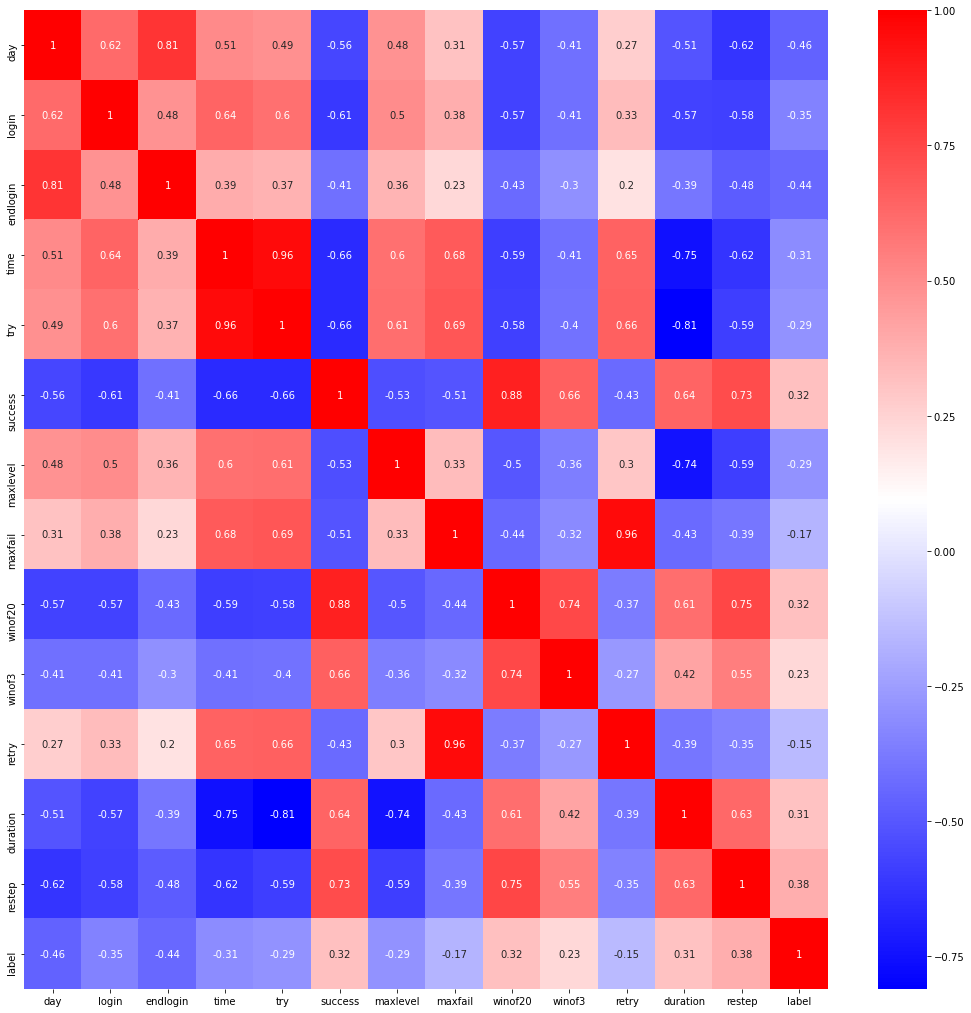

In [578]:
# 热力图
plt.subplots(figsize=(18, 18))
sns.heatmap(feature_df.corr().round(2), cmap='bwr', annot=True)


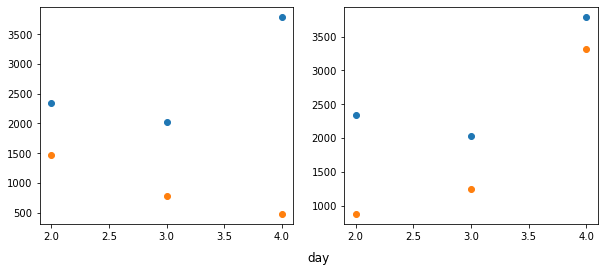

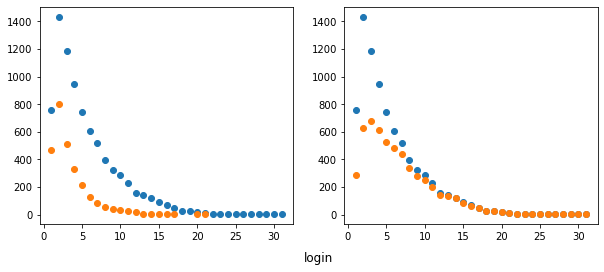

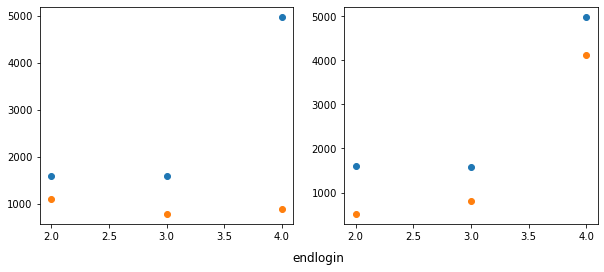

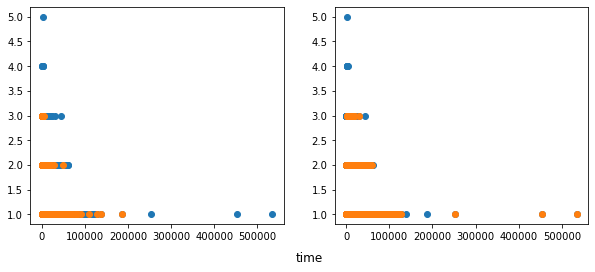

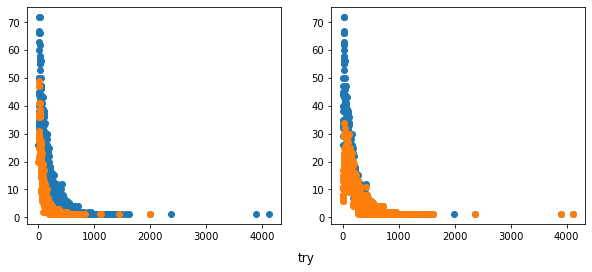

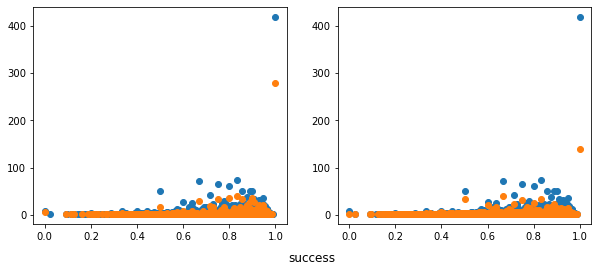

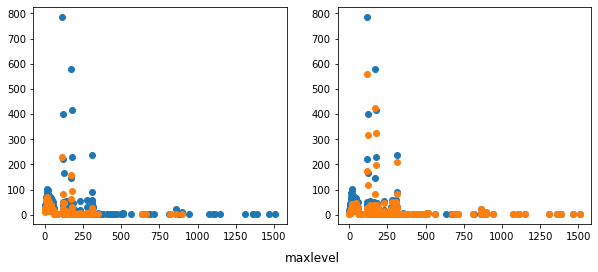

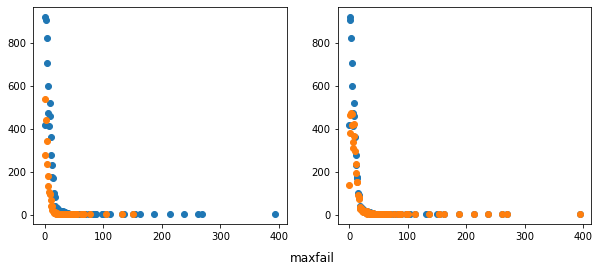

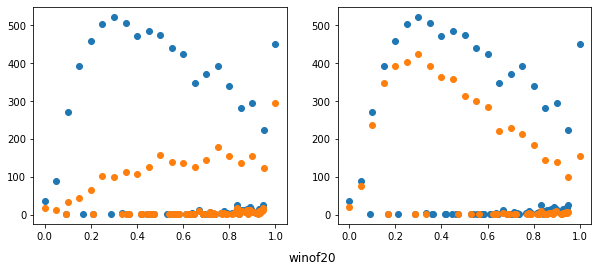

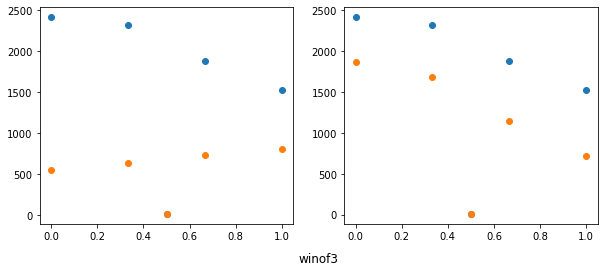

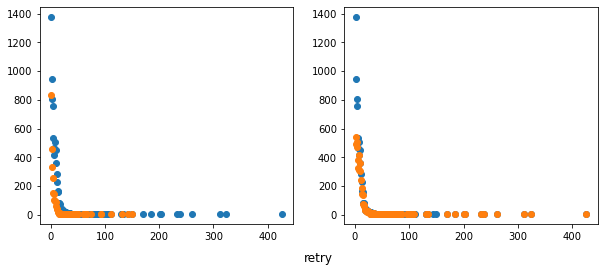

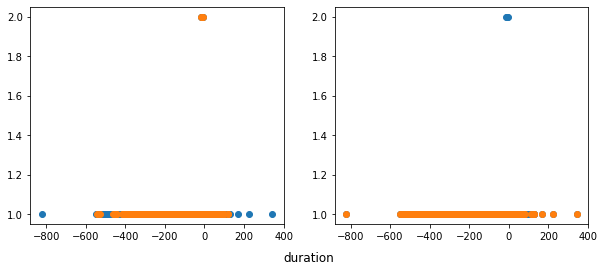

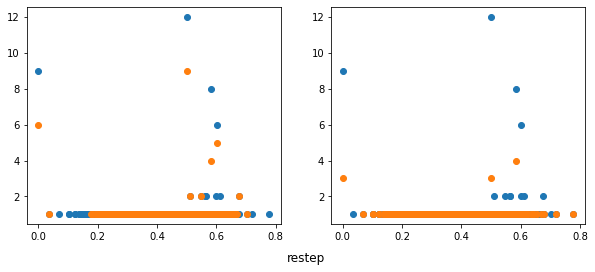

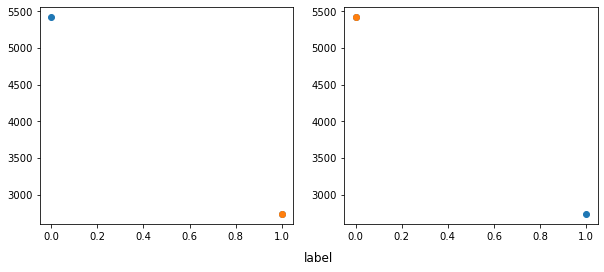

In [579]:
for co in feature_df.columns:
    a = Counter(feature_df[co])
    t = Counter(feature_df[train_df['label'] == 1][co])
    f = Counter(feature_df[train_df['label'] == 0][co])
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.scatter(a.keys(), a.values())
    plt.scatter(t.keys(), t.values())
    plt.subplot(122)
    plt.scatter(a.keys(), a.values())
    plt.scatter(f.keys(), f.values())
    plt.title(co, x=-0.1, y=-0.2)
    plt.show()


可以发现，数据存在以下规律：
- 留存的用户往往参与度较高，比如登录次数，所对应的连胜和连败的概率也越大，重试的次数也越大，往往更有信心而不是被打击
- 虽然留存用户更倾向于多次尝试，但流失的用户存在尖端数据，即连续被打击，或连续尝试**极多**次数
- 具有明显的序列性，最后几局的胜负非常关键
- 是否帮助/使用道具，连胜，开始玩的时间影响不大，可以剔除
- 能力太强和能力太弱的用户都容易流失

## 2 模型搭建

In [798]:
# 数据归一化
scaler = MinMaxScaler()
train_x = np.array(scaler.fit_transform(train_X))
valid_x = np.array(scaler.transform(valid_X))
test_x = np.array(scaler.transform(test_X))


In [799]:
clfs = dict()
clfs['LinearSVM'] = calibration.CalibratedClassifierCV(
    svm.LinearSVC(loss='squared_hinge', dual=False))
# clfs['SVC'] = svm.SVC(kernel='rbf', probability=True)
clfs['DecisionTree'] = tree.DecisionTreeClassifier(
    criterion='gini', max_depth=5, splitter='random')
clfs['GaussianNB'] = GaussianNB()
clfs['MultBayes'] = MultinomialNB(
    alpha=1, fit_prior=True)
clfs['Knn'] = KNeighborsClassifier(n_neighbors=5)


结果对比：

In [796]:
for name, clf in clfs.items():
    bcclf = BaggingClassifier(base_estimator=clf, n_estimators=50, max_samples=0.7,
                            max_features=0.7, bootstrap=True, bootstrap_features=True, n_jobs=1, random_state=1)
    bcclf.fit(train_x, train_y.flatten())
    pre = [x[1] for x in bcclf.predict_proba(valid_x)]
    fpr, tpr, thresholds = metrics.roc_curve(valid_y.flatten(), pre, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print("Bagging", name, auc)
    if name!='Knn':
        adclf = AdaBoostClassifier(base_estimator=clf, n_estimators=30,learning_rate=1,algorithm='SAMME.R')
        adclf.fit(train_x, train_y.flatten())
        pre = [x[1] for x in adclf.predict_proba(valid_x)]
        fpr, tpr, thresholds = metrics.roc_curve(
            valid_y.flatten(), pre, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        print("Boosting", name, auc)
    print()



Bagging LinearSVM 0.7903587805113776
Boosting LinearSVM 0.7854631892597677

Bagging DecisionTree 0.7924528301886793
Boosting DecisionTree 0.716464726159576

Bagging GaussianNB 0.7758994148662998
Boosting GaussianNB 0.7095404650622182

Bagging MultBayes 0.7847872818224486
Boosting MultBayes 0.7850696468920576

Bagging Knn 0.7864413599762992



In [767]:
rfclf = RandomForestClassifier(n_estimators=200,bootstrap=True)
rfclf.fit(train_x, train_y.flatten())
pre = [x[1] for x in rfclf.predict_proba(valid_x)]
fpr, tpr, thresholds = metrics.roc_curve(
    valid_y.flatten(), pre, pos_label=1)
auc = metrics.auc(fpr, tpr)
print("RandomForest",  auc)


RandomForest 0.7773769358904953


In [804]:
vclf = VotingClassifier(estimators=clfs.items(), voting='soft')
vclf.fit(train_x, train_y.flatten())



VotingClassifier(estimators=dict_items([('LinearSVM', CalibratedClassifierCV(base_estimator=LinearSVC(dual=False))), ('DecisionTree', DecisionTreeClassifier(max_depth=5, splitter='random')), ('GaussianNB', GaussianNB()), ('MultBayes', MultinomialNB(alpha=1)), ('Knn', KNeighborsClassifier())]),
                 voting='soft')

In [805]:
pre = [x[1] for x in vclf.predict_proba(valid_x)]
fpr, tpr, thresholds = metrics.roc_curve(
    valid_y.flatten(), pre, pos_label=1)
auc = metrics.auc(fpr, tpr)
print("VotingClassifier",  auc)


VotingClassifier 0.7887290223914868


In [800]:
#转化为tensor，注意这里y要转为longtensor，因为是进行交叉熵loss计算
x_train = torch.from_numpy(train_x)
y_train = torch.from_numpy(train_y).type(torch.int64)
x_test = torch.from_numpy(valid_x)
y_test = torch.from_numpy(valid_y).type(torch.int64)

# torch.utils.data.TensorDataset用于将训练集x，y合并
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

# batch size 和 轮数
batch_size = 2000
iteration_num = 50
# DataLoader用于随机播放和批量处理数据。在dataset基础上多了batch_size, shuffle等操作
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)


# 定义ann模型
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.LeakyReLU()
        # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        # self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = x.to(torch.float32)
        out = self.fc1(x)
        out = self.relu1(out)
        # out = self.fc2(out)
        # out = self.relu2(out)
        out = self.fc3(out)
        # out = self.sigmoid(out)
        return out
    
input_dim = 13              # 一维向量长度
hidden_dim = 10              # hidden layer 神经元个数
output_dim = 2              # 2个类
learning_rate = 0.01         # 学习率

model = ANNModel(input_dim, hidden_dim, output_dim)
# criterion  = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

loss_list = []
results = []
predictions=[]
weights= []
for iteration in range(iteration_num):
    for j, (data, labels) in enumerate(train_loader):
        #将其转化为变量
        train = Variable(data)
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(train)
        loss = criterion(outputs, nn.functional.one_hot(
            torch.flatten(labels), 2).type(torch.float32))
        loss.backward()
        optimizer.step()
       
        '''
        验证集accuracy计算
        '''
        if j % 5 == 0:     
            correct = 0
            total = 0 
            # result = []
            pre = []
            label = []
            for datas, labels in test_loader:
                test = Variable(datas)
                outputs = model(test)
                prediction = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (prediction == labels.flatten()).sum()
                result += list(torch.sigmoid(outputs).detach().numpy()[:, 1])
                pre += list(prediction)
                label += list(labels.detach().numpy())
            # results.append(result)
            # predictions.append(pre)
            auc = roc_auc_score(label, pre)
            weights.append(auc)
            accuracy = 100 * correct / float(total)
            loss_list.append(loss.data)
            
    if iteration % 5 ==0:
        print('Epoch:{}    Loss:{}    Accuracy:{}     Auc:{}'.format(
            iteration, loss.data, accuracy, auc))



Epoch:0    Loss:0.6859681606292725    Accuracy:33.897666931152344     Auc:0.4997296370250724
Epoch:5    Loss:0.546058714389801    Accuracy:66.10233306884766     Auc:0.5
Epoch:10    Loss:0.5054858922958374    Accuracy:74.34161376953125     Auc:0.6883112863276559
Epoch:15    Loss:0.52027428150177    Accuracy:74.30398559570312     Auc:0.6880267103458687
Epoch:20    Loss:0.5088443756103516    Accuracy:74.64258575439453     Auc:0.6908582571568807
Epoch:25    Loss:0.4610137939453125    Accuracy:75.01881408691406     Auc:0.7012741802727256
Epoch:30    Loss:0.5173001885414124    Accuracy:74.71783447265625     Auc:0.6916977720953825
Epoch:35    Loss:0.4993741512298584    Accuracy:75.13167572021484     Auc:0.7032093601177974
Epoch:40    Loss:0.5193654298782349    Accuracy:75.01881408691406     Auc:0.6999223653980874
Epoch:45    Loss:0.5146151781082153    Accuracy:74.83069610595703     Auc:0.6890367813666849


最终选择Bagging+DecisionTree，将验证集和训练集合并，生成测试集对应的标签。

In [813]:
new_x = np.concatenate([train_x, valid_x], axis = 0)
new_y = np.concatenate([train_y, valid_y], axis = 0)
print(new_x.shape, new_y.shape)

(10816, 13) (10816, 1)


In [823]:
clf = clfs['DecisionTree']
bcclf = BaggingClassifier(base_estimator=clf, n_estimators=150, max_samples=0.2,
                          max_features=0.8, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)
bcclf.fit(new_x, new_y.flatten())
pre = [x[1] for x in bcclf.predict_proba(test_x)]



In [824]:
# 提交文件
import csv
with open('./result.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['user_id', 'proba'])
    for idx, row in zip(test_df['user_id'].values, pre):
        writer.writerow([idx, row])



最开始想要使用LSTM作为模型，学校考试太多，时间来不太及了。
首先根据user_id进行数据的重新组织，因为每条seq数据存在两个维度的描述，时间和关卡。想要使用LSTM，选择更具有“序列特征”的关卡作为输入序列。

重构数据集如下：
- 每个样本为1个用户，使用用户id作为下标，其包含特征：
    * `l_max`：最大通关关卡
    * `l_ever`：每次登录玩几局
    * `t_play`：总投入时间
    * `t_inter`：平均两局之间的间隔时间，使用秒为单位
- 输入LSMT序列包含1~n关，使用关卡id作为下标，每一关卡包括：
    * `l_try`：尝试次数
    * `f_pro`：通关概率=通关次数/尝试次数
    * `f_duration`：平均尝试所用的时间（单位 s）
    * `f_reststep`：平均剩余步数与限定步数之比（失败为 0）；
    * `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；


因为关卡长度不同，所以预先使用决策树等简单模型对用户层面进行粗分类，再使用LSMT模型进行预测估计会有更好的效果。

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn


class SeriesPredictor:
    def __init__(self, input_dim, seq_size, hidden_dim=10):
        self.input_dim = input_dim  # 每次输入限量维数
        self.seq_size = seq_size  # 序列长度  time-step
        self.hidden_dim = hidden_dim  # 隐藏层维数
        self.W_out = tf.Variable(tf.random_normal(
            [hidden_dim, 1]), name='W_out')  # 权值变量
        self.b_out = tf.Variable(tf.random_normal([1]), name='b_out')  # 权值偏置
        # 生成[batch_size,seq_size,input_dim]
        self.x = tf.placeholder(tf.float32, [None, seq_size, input_dim])
        # 生成[batch_size,seq_size]
        self.y = tf.placeholder(tf.float32, [None, seq_size])
        self.cost = tf.reduce_mean(
            tf.square(self.model() - self.y))  # 损失方程，均方差
        self.train_op = tf.train.AdamOptimizer().minimize(self.cost)  # adam优化器
        self.saver = tf.train.Saver()
        """
        tf.train.Saver()-tensorflow中模型的保存及读取
作用：训练网络之后保存训练好的模型，以及在程序中读取已保存好的模型
使用步骤：
实例化一个Saver对象 saver = tf.train.Saver() 
在训练过程中，定期调用saver.save方法，像文件夹中写入包含当前模型中所有可训练变量的checkpoint文件 saver.save(sess,FLAGG.train_dir,global_step=step) 
之后可以使用saver.restore()方法，重载模型的参数，继续训练或者用于测试数据 saver.restore(sess,FLAGG.train_dir) 
在save之后会在相应的路径下面新增如下四个红色文件：
在saver实例每次调用save方法时，都会创建三个数据文件和一个检查点（checkpoint）文件，权重等参数被以字典的形式保存到.ckpt.data中，图和元数据被保存到.ckpt.meta中，可以被tf.train.import_meta_graph加载到当前默认的图
        """

    def model(self):
        cell = rnn.BasicLSTMCell(self.hidden_dim)  # 创建LSTM隐藏层
        outputs, states = tf.nn.dynamic_rnn(
            cell, self.x, dtype=tf.float32)  # 对隐层进行前进运算
        print(outputs)
        print(states)
        """
        tf.nn.dynamic_rnn(
                cell,
                inputs,
                sequence_length=None,
                initial_state=None,
                dtype=None,
                parallel_iterations=None,
                swap_memory=False,
                time_major=False,
                scope=None
                cell: RNNCell的一个实例.

inputs: RNN输入.
如果time_major == False(默认), 则是一个shape为[batch_size, max_time, input_size]的Tensor,或者这些元素的嵌套元组。
如果time_major == True,则是一个shape为[max_time, batch_size, input_size]的Tensor,或这些元素的嵌套元组。
sequence_length: (可选）大小为[batch_size],数据的类型是int32/int64向量。如果当前时间步的index超过该序列的实际长度时，
则该时间步不进行计算，RNN的state复制上一个时间步的，同时该时间步的输出全部为零。

initial_state: (可选)RNN的初始state(状态)。如果cell.state_size(一层的RNNCell)是一个整数
，那么它必须是一个具有适当类型和形状的张量[batch_size，cell.state_size]。如果cell.state_size是一个元组(多层的RNNCell,如MultiRNNCell)，
那么它应该是一个张量元组，每个元素的形状为[batch_size，s] for s in cell.state_size。

time_major: inputs 和outputs 张量的形状格式。如果为True，则这些张量都应该是（都会是）[max_time, batch_size, depth]。如果为false，
则这些张量都应该是（都会是）[batch_size，max_time, depth]。time_major=true说明输入和输出tensor的第一维是max_time。否则为batch_size。
使用time_major =True更有效,因为它避免了RNN计算开始和结束时的转置.但是,大多数TensorFlow数据都是batch-major,因此默认情况下,此函数接受输入并以batch-major形式发出输出.
返回值：
一对(outputs, state),其中：
outputs： RNN输出Tensor.
如果time_major == False(默认),这将是shape为[batch_size, max_time, cell.output_size]的Tensor.
如果time_major == True,这将是shape为[max_time, batch_size, cell.output_size]的Tensor.
state： 最终的状态.
一般情况下state的形状为 [batch_size, cell.output_size ]
如果cell是LSTMCells,则state将是包含每个单元格的LSTMStateTuple的元组，state的形状为[2，batch_size, cell.output_size ]

        """
        num_examples = tf.shape(self.x)[0]  # 获取batchsize大小
        # 变化为[batch_size,seq_size, input_dim]
        W_repeated = tf.tile(tf.expand_dims(
            self.W_out, 0), [num_examples, 1, 1])
        # tf.expand_dims,0号位增加一个新的维度，再将矩阵进行扩展
        # W_repeated = tf.tile(tf.expand_dims(self.W_out, 0), [num_examples, 1, 1])变为[batchsize,hidden_dim,1]
        # tf_expand维度（1,10,1）
        """
        tf.tile(
            input,
            multiples,
            name=None
        )
input是待扩展的张量，multiples是扩展方法。
假如input是一个3维的张量。那么mutiples就必须是一个1x3的1维张量。这个张量的三个值依次表示input的第1，第2，第3维数据扩展几倍。
        """
        out = tf.matmul(outputs, W_repeated) + self.b_out  # 实现全连接层
        out = tf.squeeze(out)
        """
        squeeze(
        input,
        axis=None,
        name=None,
        squeeze_dims=None
)
 从tensor中删除所有大小是1的维度
 给定张量输入，此操作返回相同类型的张量，并删除所有尺寸为1的尺寸。 如果不想删除所有大小是1的维度，可以通过squeeze_dims指定。
        """
        return out

    """
    :param x: inputs of size [T, batch_size, input_size]
    :param W: matrix of fully-connected output layer weights
    :param b: vector of fully-connected output layer biases
    """

    def train(self, train_x, train_y):  # 训练函数
        with tf.Session() as sess:  # 建立会话
            tf.get_variable_scope().reuse_variables()  # 设置变量共享
            sess.run(tf.global_variables_initializer())  # 会话执行变量初始化
            # 迭代次数
            for i in range(1000):
                _, mse = sess.run([self.train_op, self.cost], feed_dict={
                                  self.x: train_x, self.y: train_y})
                if i % 100 == 0:
                    print(i, mse)
            save_path = self.saver.save(sess, './model')
            print('Model saved to {}'.format(save_path))

    def test(self, test_x):  # 取出模型对数据进行匹配
        with tf.Session() as sess:
            tf.get_variable_scope().reuse_variables()  # 变量共享
            self.saver.restore(sess, './model')  # 存储模型
            output = sess.run(self.model(), feed_dict={self.x: test_x})
            return output


if __name__ == '__main__':
    predictor = SeriesPredictor(input_dim=1, seq_size=4, hidden_dim=10)

    predictor.train(train_x, train_y)


    pred_y = predictor.test(test_x)

    print("\nlets run some tests!\n")

    for i, x in enumerate(test_x):
        print('when the inputs is {}'.format(x))
        print('the ground truth output should be {}'.format(valid_y[i]))
        print('and the model thinks it is {}\n'.format(pred_y[i]))
